## 1. Load data from file

In [0]:
import numpy as np
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_PATH = './mnist.csv'
SIZE_ROW = 28
SIZE_COL = 28

# load data from file
data = torch.from_numpy(
    np.genfromtxt(DATA_PATH, delimiter=',')
)

# separate pixel values from labels
X_raw = data[:, 1:]
Y_raw = data[:, 0]

## 2. Data preprocessing

In [0]:
# normalize X data
X_data = (X_raw - torch.min(X_raw)) / (torch.max(X_raw) - torch.min(X_raw))

# one-hot encoding Y data
Y_data = Y_raw.to(torch.long)
Y_data = torch.eye(torch.unique(Y_data).shape[0])[Y_data]

# train data
X_train = X_data[:1000].to(device)
Y_train = Y_data[:1000].to(device)

# test data
X_test = X_data[1000:].to(device)
Y_test = Y_data[1000:].to(device)

## 3. Define model and functions for learning neural network

In [0]:
import math

def initialize_weights(fan_in, fan_out):
  # xavier initialization
  return math.sqrt(1 / fan_in) * torch.randn(fan_out, fan_in)

def activation(z):
  return 1 / (1 + torch.exp(-z))

def objective(Y_pred, Y, lam=0, params=None):
  epsilon = 1e-8
  data_fidelity_term = (-1 / Y.shape[0]) * torch.sum(
      Y * torch.log(Y_pred + epsilon) + (1 - Y) * torch.log(1 - Y_pred + epsilon)
  )

  decay_term = 0
  if lam is not 0:
    num_of_params = 0   # n
    sum_of_params = 0   # sigma theta^2
    for param in params.values():
      num_of_params += param.shape[0] * param.shape[1]
      sum_of_params += torch.sum(param ** 2)

    decay_term = (lam / (2 * num_of_params)) * sum_of_params

  return data_fidelity_term + decay_term

def accuracy(Y_pred, Y):
  answer_Y_pred = torch.argmax(Y_pred, axis=1)
  answer_Y = torch.argmax(Y, axis=1)
  return torch.mean((answer_Y_pred == answer_Y).float())


class FNN:
  def __init__(self, layer_size_list):
    self.num_of_layer = len(layer_size_list) - 1
    self.params = dict()

    # initialize params w and b (w is weights and b is biases)
    for i in range(len(layer_size_list) - 1):
      fan_in = layer_size_list[i]
      fan_out = layer_size_list[i + 1]

      self.params['w' + str(i + 1)] = initialize_weights(fan_in, fan_out).double().to(device)
      self.params['b' + str(i + 1)] = torch.zeros(1, fan_out).double().to(device)

  def forward(self, X):
    forward_results = dict()
    forward_results['a0'] = X

    # z is fully connected layer's result and
    # a is activation function's result
    for i in range(self.num_of_layer):
      prev_a = forward_results['a' + str(i)]
      curr_w = self.params['w' + str(i + 1)]
      curr_b = self.params['b' + str(i + 1)]

      forward_results['z' + str(i + 1)] = torch.matmul(prev_a, curr_w.T) + curr_b
      forward_results['a' + str(i + 1)] = activation(forward_results['z' + str(i + 1)])

    forward_results['Y_pred'] = forward_results['a' + str(self.num_of_layer)]

    return forward_results

  def backward(self, X, Y, forward_results, lam=0):
    grads = dict()

    dz_last = (forward_results['a' + str(self.num_of_layer)] - Y) / X.shape[0]

    # reverse order because of `back`ward propagation
    for i in range(self.num_of_layer)[::-1]:
      curr_a = forward_results['a' + str(i + 1)]
      next_a = forward_results['a' + str(i)]

      if i == (self.num_of_layer - 1):  # if last layer
        grads['z' + str(i + 1)] = (curr_a - Y) / X.shape[0]
      else:
        prev_dz = grads['z' + str(i + 2)]
        prev_w = self.params['w' + str(i + 2)]

        grads['a' + str(i + 1)] = torch.matmul(prev_dz, prev_w)
        grads['z' + str(i + 1)] = curr_a * (1 - curr_a) * grads['a' + str(i + 1)]

      grads['w' + str(i + 1)] = torch.matmul(grads['z' + str(i + 1)].T, next_a)
      grads['b' + str(i + 1)] = torch.sum(grads['z' + str(i + 1)], axis=0).reshape(1, -1)

    # remain only the gradients of w and b
    for key in list(grads.keys()):
      if key.startswith('z') or key.startswith('a'):
        del grads[key]

    # apply gradients of decay term
    if lam is not 0:
      n = 0
      for param in self.params.values():
        n += param.shape[0] * param.shape[1]

      for key in grads.keys():
        grads[key] += (lam / n) * self.params[key]

    return grads

## 4. Learning with the gradient descent algorithm


In [0]:
lr = 0.7
lam = 52
epoch_count = 4000
fnn = FNN((784, 100, 400, 10))

history = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': []
}

for epoch in range(epoch_count):
  # forward propagation using train data
  train_forward_results = fnn.forward(X_train)

  # calculate training loss and accuracy
  Y_train_pred = train_forward_results['Y_pred']
  train_loss = objective(Y_train_pred, Y_train, lam, fnn.params)
  train_acc = accuracy(Y_train_pred, Y_train)

  # forward propagation using test data
  test_forward_results = fnn.forward(X_test)

  # calculate testing loss and accuracy
  Y_test_pred = test_forward_results['Y_pred']
  test_loss = objective(Y_test_pred, Y_test, lam, fnn.params)
  test_acc = accuracy(Y_test_pred, Y_test)

  # log history
  history['train_loss'].append(train_loss.item())
  history['test_loss'].append(test_loss.item())
  history['train_acc'].append(train_acc.item())
  history['test_acc'].append(test_acc.item())

  # gradient descent
  grads = fnn.backward(X_train, Y_train, train_forward_results, lam)
  for key in fnn.params.keys():
    fnn.params[key] -= lr * grads[key]

# convert each history list to numpy array
for key in history.keys():
  history[key] = np.array(history[key])

## 5. Prepare classification example

In [0]:
Y_test_pred = fnn.forward(X_test)['Y_pred']
answer_Y_test_pred = torch.argmax(Y_test_pred, axis=1)
answer_Y_test = torch.argmax(Y_test, axis=1)

# compare predicted labels with real labels
correct_mask = answer_Y_test_pred == answer_Y_test
mis_mask = answer_Y_test_pred != answer_Y_test

# seperate correctly classificed images from misclassified images in the testing image set
correct_images = X_test[correct_mask]
correct_labels = answer_Y_test_pred[correct_mask]
mis_images = X_test[mis_mask]
mis_labels = answer_Y_test_pred[mis_mask]

# randomly choice 10 images each of them
random_indices_for_correct = torch.randperm(correct_images.shape[0])[:10]
random_indices_for_mis = torch.randperm(mis_images.shape[0])[:10]

correct_images = correct_images[random_indices_for_correct]
correct_labels = correct_labels[random_indices_for_correct]
mis_images = mis_images[random_indices_for_mis]
mis_labels = mis_labels[random_indices_for_mis]

## 6. Results


### 6-1. Plot the loss curve

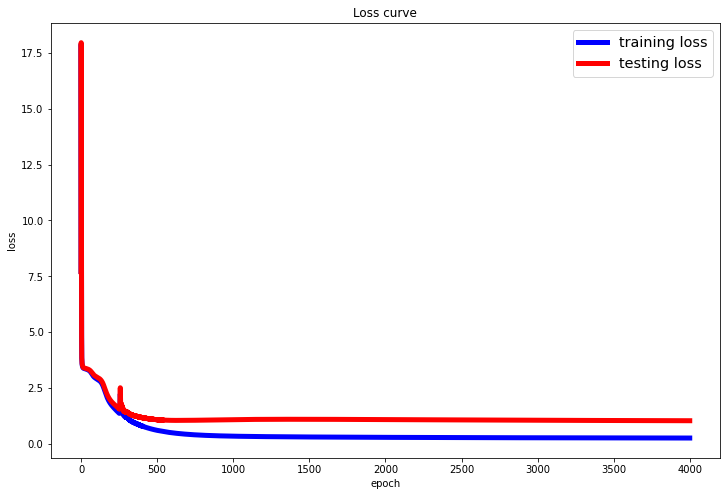

In [191]:
import matplotlib.pyplot as plt

epoch_tick = np.arange(epoch_count)

plt.figure(figsize=(12, 8))
plt.title('Loss curve')
plt.plot(epoch_tick, history['train_loss'], 'b-', linewidth=5)
plt.plot(epoch_tick, history['test_loss'], 'r-', linewidth=5)
plt.legend(['training loss', 'testing loss'], fontsize='x-large', loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 6-2. Plot the accuracy curve

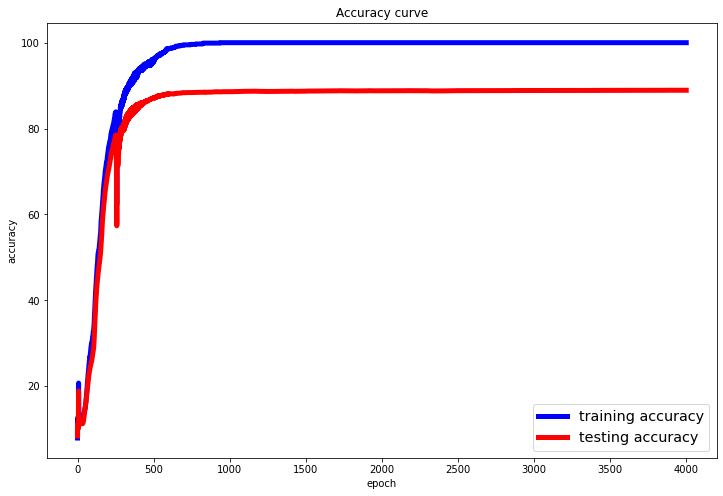

In [192]:
plt.figure(figsize=(12, 8))
plt.title('Accuracy curve')
plt.plot(epoch_tick, history['train_acc'] * 100, 'b-', linewidth=5)
plt.plot(epoch_tick, history['test_acc'] * 100, 'r-', linewidth=5)
plt.legend(['training accuracy', 'testing accuracy'], fontsize='x-large', loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

### 6-3. Plot the accuracy value

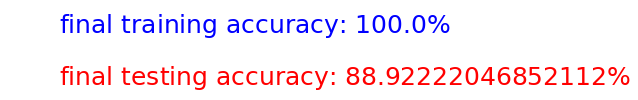

In [193]:
final_train_acc = history['train_acc'][-1] * 100
final_test_acc = history['test_acc'][-1] * 100

ax = plt.axes([0, 0, 0.6, 0.3])
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.text(0.2, 0.7, f'final training accuracy: ${final_train_acc}$%', size=25, color='blue')
plt.text(0.2, 0.1, f'final testing accuracy: ${final_test_acc}$%', size=25, color='red')
plt.show()

### 6-4. Plot the classification example

#### 6-4-1. Correctly classified testing images

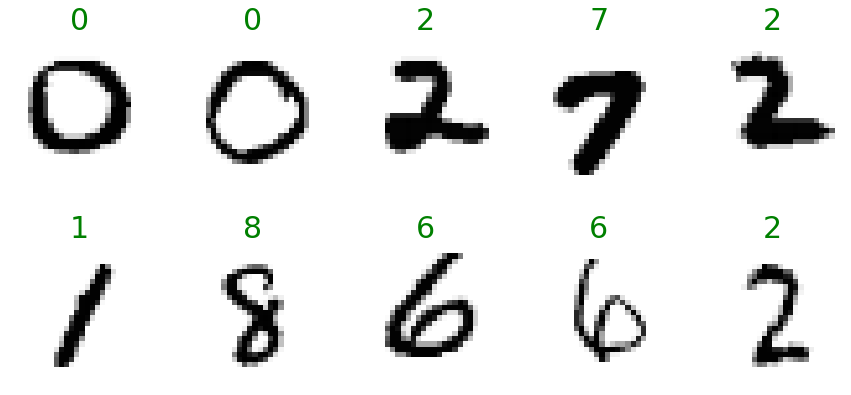

In [195]:
plt.figure(figsize=(15, 7))

for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.title(correct_labels[i].item(), fontsize=30, color='green')
  plt.imshow(correct_images[i].reshape(SIZE_ROW, SIZE_COL).to('cpu'), cmap='Greys', interpolation='None')
  plt.axis('off')

plt.show()

#### 6-4-2. Misclassified testing images

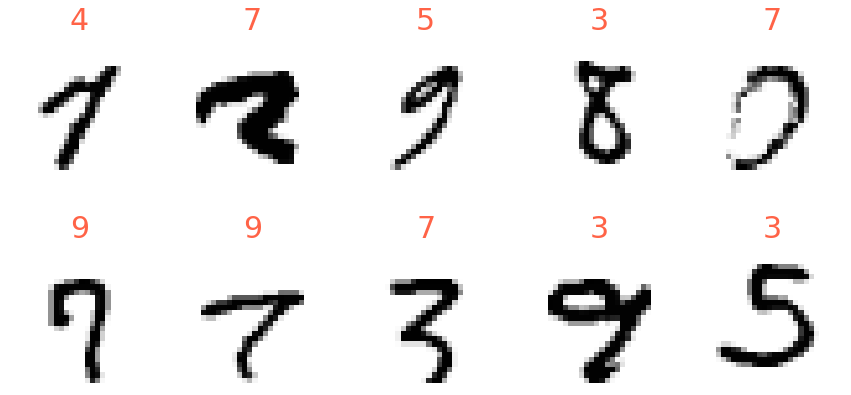

In [196]:
plt.figure(figsize=(15, 7))

for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.title(mis_labels[i].item(), fontsize=30, color='tomato')
  plt.imshow(mis_images[i].reshape(SIZE_ROW, SIZE_COL).to('cpu'), cmap='Greys', interpolation='None')
  plt.axis('off')

plt.show()